In [2]:
import os
import cv2
import numpy as np
import math
import sys

In [4]:
def readPoints(path) :
    # Create an array of array of points.
    pointsArray = []
    
    #List all files in the directory and read points from text files one by one
    for filePath in sorted(os.listdir(path)):
        
        if filePath.endswith(".txt"):
            
            #Create an array of points.
            points = []
            
            # Read points from filePath
            with open(os.path.join(path, filePath)) as file :
                for line in file :
                    x, y = line.split()
                    points.append((int(x), int(y)))
            
            # Store array of points
            pointsArray.append(points)
            
    return pointsArray

In [6]:
def readImages(path) :
    
    #Create array of array of images.
    imagesArray = []
    
    #List all files in the directory and read points from text files one by one
    for filePath in sorted(os.listdir(path)):
       
        if filePath.endswith(".jpg"):
            # Read image found.
            img = cv2.imread(os.path.join(path,filePath))

            # Convert to floating point
            img = np.float32(img)/255.0

            # Add to array of images
            imagesArray.append(img)
            
    return imagesArray

In [26]:
def similarityTransform(inPoints, outPoints) :
    s60 = math.sin(60*math.pi/180)
    c60 = math.cos(60*math.pi/180)  
  
    inPts = np.copy(inPoints).tolist()
    outPts = np.copy(outPoints).tolist()
    
    xin = c60*(inPts[0][0] - inPts[1][0]) - s60*(inPts[0][1] - inPts[1][1]) + inPts[1][0]
    yin = s60*(inPts[0][0] - inPts[1][0]) + c60*(inPts[0][1] - inPts[1][1]) + inPts[1][1]
    
    inPts.append([int(xin), int(yin)])

    xout = c60*(outPts[0][0] - outPts[1][0]) - s60*(outPts[0][1] - outPts[1][1]) + outPts[1][0]
    yout = s60*(outPts[0][0] - outPts[1][0]) + c60*(outPts[0][1] - outPts[1][1]) + outPts[1][1]
    
    outPts.append([int(xout), int(yout)])
    
    tform = cv2.estimateAffinePartial2D(np.array([inPts]), np.array([outPts]))
    
    return tform[0]

In [28]:
def rectContains(rect, point) :
    if point[0] < rect[0] :
        return False
    elif point[1] < rect[1] :
        return False
    elif point[0] > rect[2] :
        return False
    elif point[1] > rect[3] :
        return False
    return True

In [30]:
# Calculate delanauy triangle
def calculateDelaunayTriangles(rect, points):
    # Create subdiv
    subdiv = cv2.Subdiv2D(rect)
   
    # Insert points into subdiv
    for p in points:
        subdiv.insert((p[0], p[1]))

   
    # List of triangles. Each triangle is a list of 3 points ( 6 numbers )
    triangleList = subdiv.getTriangleList()

    # Find the indices of triangles in the points array

    delaunayTri = []
    
    for t in triangleList:
        pt = []
        pt.append((t[0], t[1]))
        pt.append((t[2], t[3]))
        pt.append((t[4], t[5]))
        
        pt1 = (t[0], t[1])
        pt2 = (t[2], t[3])
        pt3 = (t[4], t[5])        
        
        if rectContains(rect, pt1) and rectContains(rect, pt2) and rectContains(rect, pt3):
            ind = []
            for j in range(0, 3):
                for k in range(0, len(points)):                    
                    if(abs(pt[j][0] - points[k][0]) < 1.0 and abs(pt[j][1] - points[k][1]) < 1.0):
                        ind.append(k)                            
            if len(ind) == 3:                                                
                delaunayTri.append((ind[0], ind[1], ind[2]))
        

    
    return delaunayTri

In [32]:
def constrainPoint(p, w, h) :
    p =  ( min( max( p[0], 0 ) , w - 1 ) , min( max( p[1], 0 ) , h - 1 ) )
    return p

# Apply affine transform calculated using srcTri and dstTri to src and
# output an image of size.
def applyAffineTransform(src, srcTri, dstTri, size) :
    
    # Given a pair of triangles, find the affine transform.
    warpMat = cv2.getAffineTransform( np.float32(srcTri), np.float32(dstTri) )
    
    # Apply the Affine Transform just found to the src image
    dst = cv2.warpAffine( src, warpMat, (size[0], size[1]), None, flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101 )

    return dst

In [34]:
def warpTriangle(img1, img2, t1, t2) :

    # Find bounding rectangle for each triangle
    r1 = cv2.boundingRect(np.float32([t1]))
    r2 = cv2.boundingRect(np.float32([t2]))

    # Offset points by left top corner of the respective rectangles
    t1Rect = [] 
    t2Rect = []
    t2RectInt = []

    for i in range(0, 3):
        t1Rect.append(((t1[i][0] - r1[0]),(t1[i][1] - r1[1])))
        t2Rect.append(((t2[i][0] - r2[0]),(t2[i][1] - r2[1])))
        t2RectInt.append(((t2[i][0] - r2[0]),(t2[i][1] - r2[1])))


    # Get mask by filling triangle
    mask = np.zeros((r2[3], r2[2], 3), dtype = np.float32)
    cv2.fillConvexPoly(mask, np.int32(t2RectInt), (1.0, 1.0, 1.0), 16, 0)

    # Apply warpImage to small rectangular patches
    img1Rect = img1[r1[1]:r1[1] + r1[3], r1[0]:r1[0] + r1[2]]
    
    size = (r2[2], r2[3])

    img2Rect = applyAffineTransform(img1Rect, t1Rect, t2Rect, size)
    
    img2Rect = img2Rect * mask

    # Copy triangular region of the rectangular patch to the output image
    img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] = img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] * ( (1.0, 1.0, 1.0) - mask )
     
    img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] = img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] + img2Rect

In [39]:
if __name__ == '__main__' :
    
    path = r'C:\Users\gowri\OneDrive\Desktop\face average\presidents'
    
    # Dimensions of output image
    w = 600
    h = 600

    # Read points for all images
    allPoints = readPoints(path)
    
    # Read all images
    images = readImages(path)
    
    # Eye corners
    eyecornerDst = [ (int(0.3 * w), int(h / 3)), (int(0.7 * w), int(h / 3)) ]

    
    imagesNorm = []
    pointsNorm = []
    
    # Add boundary points for delaunay triangulation
    boundaryPts = np.array([(0,0), (w/2,0), (w-1,0), (w-1,h/2), ( w-1, h-1 ), ( w/2, h-1 ), (0, h-1), (0,h/2) ])
    
    # Initialize location of average points to 0s
    pointsAvg = np.array([(0,0)]* ( len(allPoints[0]) + len(boundaryPts) ), np.float32())
    
    n = len(allPoints[0])

    numImages = len(images)
    
    # Warp images and trasnform landmarks to output coordinate system,
    # and find average of transformed landmarks.
    
    for i in range(0, numImages):

        points1 = allPoints[i]

        # Corners of the eye in input image
        eyecornerSrc  = [ allPoints[i][36], allPoints[i][45] ] 
        
        # Compute similarity transform
        tform = similarityTransform(eyecornerSrc, eyecornerDst)
        
        # Apply similarity transformation
        img = cv2.warpAffine(images[i], tform, (w,h))

        # Apply similarity transform on points
        points2 = np.reshape(np.array(points1), (68,1,2))
        
        points = cv2.transform(points2, tform)
        
        points = np.float32(np.reshape(points, (68, 2)))
        
        # Append boundary points. Will be used in Delaunay Triangulation
        points = np.append(points, boundaryPts, axis=0)
        
        # Calculate location of average landmark points.
        pointsAvg = pointsAvg + points / numImages
        
        pointsNorm.append(points)
        imagesNorm.append(img)
    

    
    # Delaunay triangulation
    rect = (0, 0, w, h)
    dt = calculateDelaunayTriangles(rect, np.array(pointsAvg))

    # Output image
    output = np.zeros((h,w,3), np.float32())

    # Warp input images to average image landmarks
    for i in range(0, len(imagesNorm)) :
        img = np.zeros((h,w,3), np.float32())
        # Transform triangles one by one
        for j in range(0, len(dt)) :
            tin = []
            tout = []
            
            for k in range(0, 3) :                
                pIn = pointsNorm[i][dt[j][k]]
                pIn = constrainPoint(pIn, w, h)
                
                pOut = pointsAvg[dt[j][k]]
                pOut = constrainPoint(pOut, w, h)
                
                tin.append(pIn)
                tout.append(pOut)
            
            
            warpTriangle(imagesNorm[i], img, tin, tout)


        # Add image intensities for averaging
        output = output + img


    # Divide by numImages to get average
    output = output / numImages

    # Display result
    cv2.imshow('image', output)
    cv2.waitKey(0)

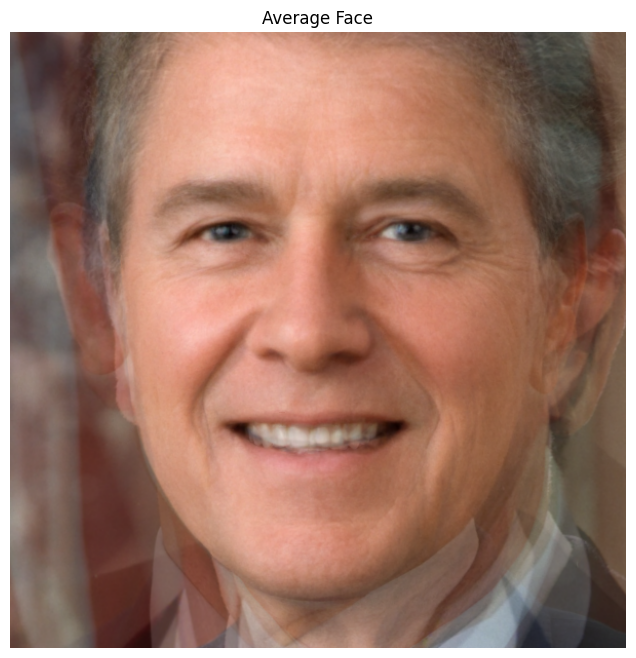

In [43]:
import matplotlib.pyplot as plt

# Convert from BGR to RGB
output_normalized = cv2.normalize(output, None, 0, 255, cv2.NORM_MINMAX)
output_rgb = cv2.cvtColor(np.uint8(output_normalized), cv2.COLOR_BGR2RGB)

# Show the image using matplotlib
plt.figure(figsize=(8, 8))
plt.imshow(output_rgb)
plt.axis('off')
plt.title('Average Face')
plt.show()